# Recommendation 5: Assessing Model Fits in Time-Resolved Spectral Parameterization


### Issue

Within the specparam tool, there are two goodness-of-fit metrics to assess how well your model is fitting your data: R-squared and mean squared error. Power spectra fit can be influenced by many factors, such as short time windows, sample size, and model hyperparameter specifications. 

### Solution

Here, we walk through some examples of how to investigate model fits based on these various factors.

### Related Work

The following papers include discussion of this topic:

- [LINK](LINK), AUTHORS, YEAR

### Related Discussion / Examples

The following examples discuss related topics:
-  [LINK](LINK), DESCRIPTION

In [1]:
# General imports
import numpy as np
import matplotlib.pyplot as plt

# Import the model objects
from specparam import SpectralModel, SpectralGroupModel

# Import some utilities for creating simulated power-spectra and calculating error
from specparam.sim import sim_power_spectrum
from specparam.sim.utils import set_random_seed
from specparam.measures.error import compute_pointwise_error

# Import some utilities for simulating time series
from neurodsp.sim import sim_combined, sim_knee, sim_peak_oscillation, sim_powerlaw
from neurodsp.spectral import compute_spectrum
from neurodsp.plts.time_series import plot_time_series
from neurodsp.utils import create_times, set_random_seed

In [2]:
# Add path and import custom code for the project
import sys
sys.path.append('code')

### Settings

In [3]:
import seaborn as sns
sns.set_context('poster')

In [4]:
# Set random seed
set_random_seed(808)

In [5]:
# Set whether to save out figures
SAVE_FIG = False

### It can also be useful to visualize the frequency-by-frequency error of model fits

We can simulate a power spectrum with a 10 Hz oscillation, *without* a knee, fit it without a knee, and test the error across frequncies

                                                                                                  
                                       POWER SPECTRUM MODEL                                       
                                                                                                  
                        The model was run on the frequency range 3 - 50 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          1.0267, 1.0163                                          
                                                                                                  
                                       1 peaks were found:                                        
          

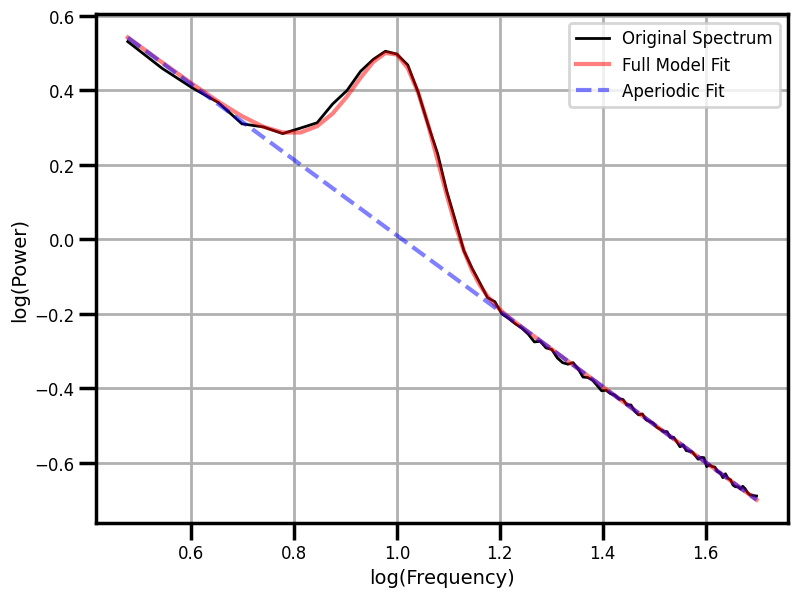

In [37]:
# Simulate an example power spectrum, with no knee, and a 10 Hz oscillatory peak
freqs, powers = sim_power_spectrum(freq_range=[3, 50], aperiodic_params=[1, 1], 
                                   periodic_params=[10, 0.5, 2])

# Initialize a model object
fm = SpectralModel(peak_width_limits=[1,8])

# Parameterize our power spectrum
fm.report(freqs, powers, plt_log=True)

When you plot the errors across frequencies, it is largely uniformly distributed, which is a good sign that model fits aren't being driven by a certain frequency.

Average freq-by-freq error:	 0.006


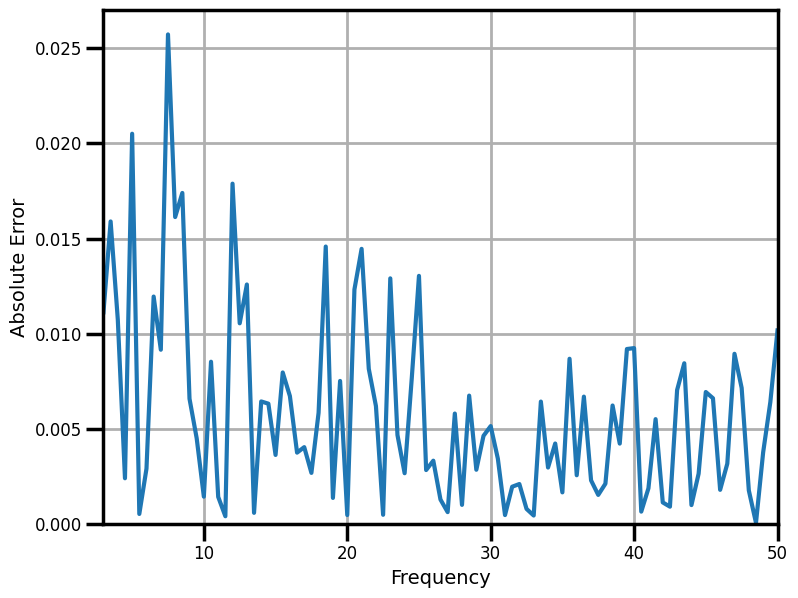

In [38]:
# Calculate the error per frequency of the model
compute_pointwise_error(fm, plot_errors=True)

# We can also use this function to return the frequency-by-frequency error
errs_fm = compute_pointwise_error(fm, plot_errors=False, return_errors=True)
print('Average freq-by-freq error:\t {:1.3f}'.format(np.mean(errs_fm)))

To see an example of a non-uniformly distributed frequency error plot, we can simualte a power spectrum *with* a knee, and fit it *without* a knee.


	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                       POWER SPECTRUM MODEL                                       
                                                                                                  
                        The model was run on the frequency range 3 - 50 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     0.1224, 15.2

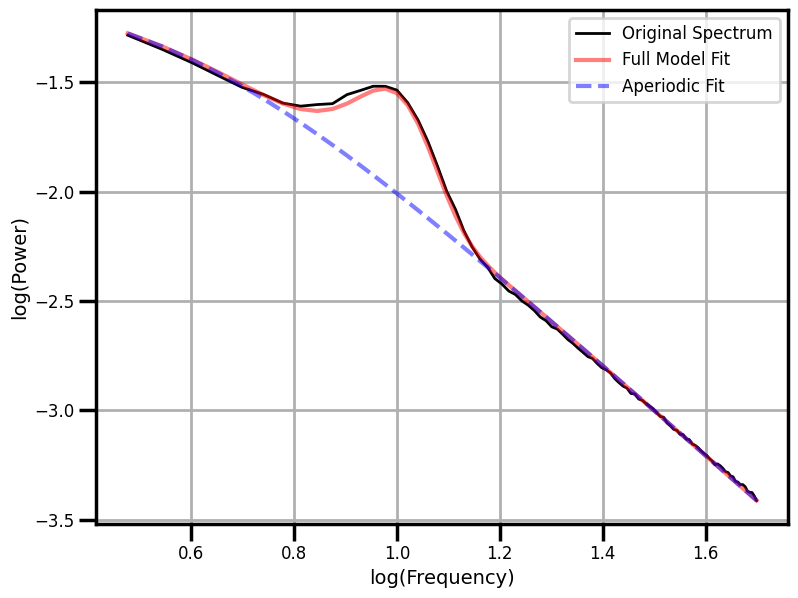

In [41]:
freqs, powers = sim_power_spectrum(freq_range=[3, 50], aperiodic_params=[0, 10, 2], 
                                   periodic_params=[10, 0.5, 2])
fm = SpectralModel(aperiodic_mode='knee')
fm.report(freqs, powers, plt_log=True)


	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                       POWER SPECTRUM MODEL                                       
                                                                                                  
                        The model was run on the frequency range 3 - 50 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -0.2544,

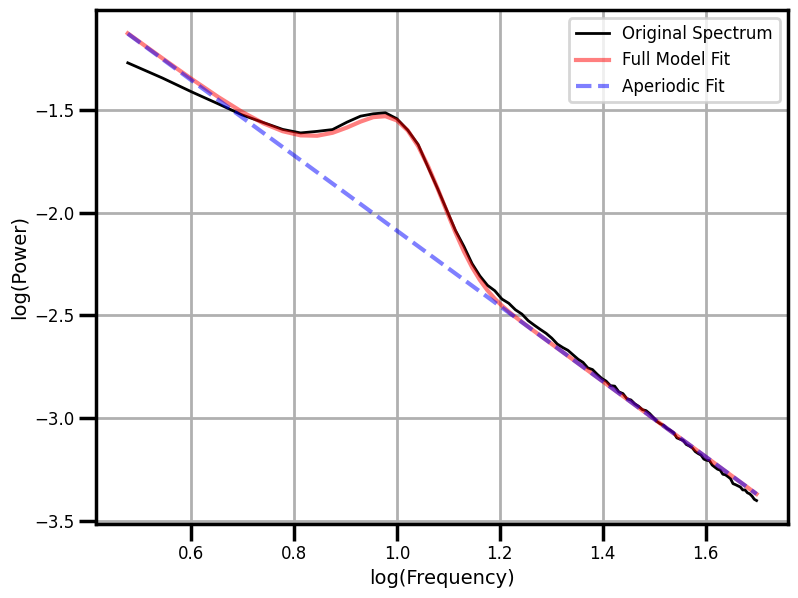

In [43]:
freqs, powers = sim_power_spectrum(freq_range=[3, 50], aperiodic_params=[0, 10, 2], 
                                   periodic_params=[10, 0.5, 2])
fm = SpectralModel()
fm.report(freqs, powers, plt_log=True)

When we plot the pointwise frequency error for this fit, we see the error is unusually high for lower frequencies compared to higher ones, indicating some issue with how we fit the data.

Average freq-by-freq error:	 0.019


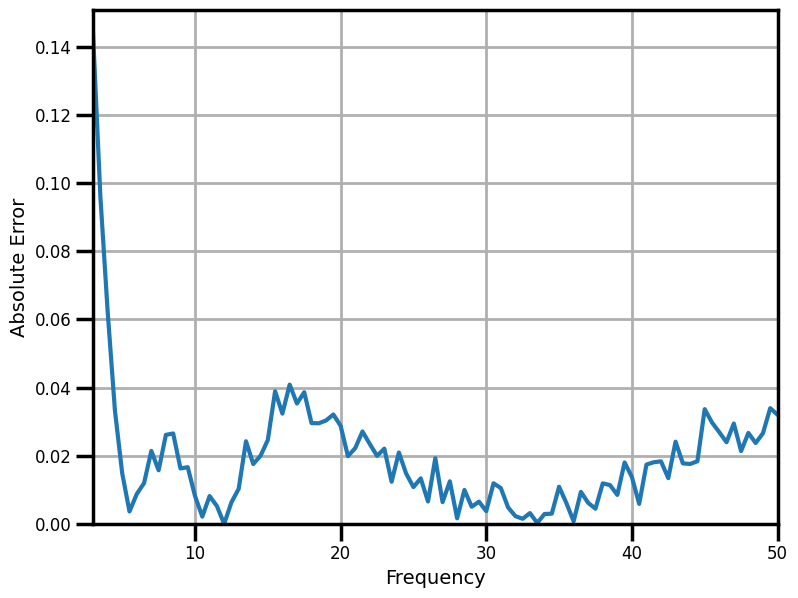

In [44]:
# Calculate the error per frequency of the model
compute_pointwise_error(fm, plot_errors=True)

# We can also use this function to return the frequency-by-frequency error
errs_fm = compute_pointwise_error(fm, plot_errors=False, return_errors=True)
print('Average freq-by-freq error:\t {:1.3f}'.format(np.mean(errs_fm)))

If you are getting consistently poor fits, consider increasing your window size or using another method better suited for shorter time spans, such as the multitaper method

### Conclusion

<>